In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pylab as pl
import math
import numpy.random as nrand
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import statsmodels.stats.stattools as tm
import scipy
from scipy.signal import savgol_filter as savitzky_golay
from scipy.signal import find_peaks_cwt

In [2]:
gold = pd.read_csv('../Commodity/gold.csv',parse_dates=True)
oil = pd.read_csv('../Commodity/crude_oil.csv',parse_dates=True,skiprows=1)

In [3]:
#Loading the data sets
df_gold = pd.DataFrame(gold,dtype=object)
df_gold.columns = ['Date','Gold Fixing Price']
df_gold = df_gold.replace('.', np.nan)
df_gold['Gold Fixing Price'] = pd.to_numeric(df_gold['Gold Fixing Price'])
df_gold.dropna(inplace=False)

df_oil = pd.DataFrame(oil)
df_oil.columns = ['Date','Crude Oil Price']


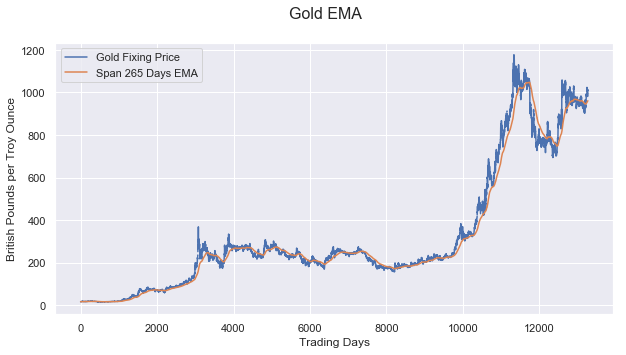

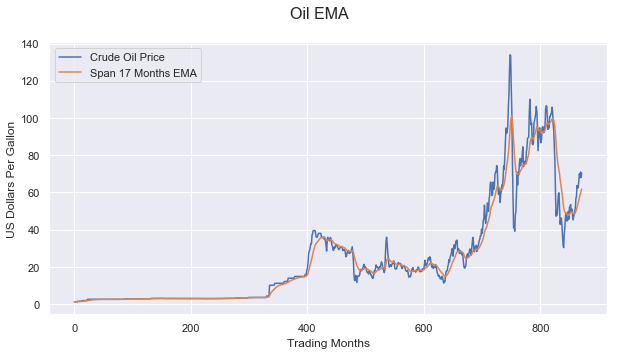

In [4]:
def EMA(df,col_name,size,label,frequency,title):
    #Exponential Moving Average calculations
    #adjust=False specifies that we are interested in the recursive calculation mode.
    if col_name == col_name_gold:
        df.to_pickle('./datagold.pkl')
        data = pd.read_pickle('./datagold.pkl')
    else:
        df.to_pickle('./dataoil.pkl')
        data = pd.read_pickle('./dataoil.pkl')
    
    #short window set to the size of the dataframe divided by 50
    short = size/50
    long = 500
    
    #calculation of rolling mean and volatility
    ema_long = data.ewm(span=long, adjust=False).mean()
    ema_long_vol = data.ewm(span=long, adjust=False).var()
    ema_short = data.ewm(span=short, adjust=False).mean()
    ema_short_vol = data.ewm(span=short, adjust=False).var()
    
    #Smoothing parameter
    alpha = 2/(short+1)
    #Residual from EMA to price data
    residual = data.set_index('Date') - ema_short.set_index('Date')

    #Plotting of price time series vs. EMA
    fig, ax = plt.subplots(figsize=(10,5))
    fig.suptitle(title, fontsize=16)
    ax.plot(data.loc[0:len(data), :].index, data.loc[0:len(data), col_name],label=col_name)
    ax.plot(ema_short.loc[0:len(ema_short), :].index, ema_short.loc[0:len(ema_short), col_name],\
            label='Span ' + str(short) + ' ' + str(frequency) + ' EMA')
    ax.legend(loc='best')
    ax.set_xlabel('Trading ' + str(frequency))
    ax.set_ylabel(str(label))
    plt.show()

    return data,ema_short,ema_short_vol,alpha,residual

sns.set()

dataframe_gold = df_gold.reset_index()
col_name_gold = 'Gold Fixing Price'
size_gold = dataframe_gold.shape[0]

dataframe_oil = df_oil.reset_index()
col_name_oil = 'Crude Oil Price'
size_oil = dataframe_oil.shape[0]

gold_data,gold_ema_short,gold_volatility,gold_alpha,gold_residual \
                = EMA(dataframe_gold,col_name_gold,size_gold,'British Pounds per Troy Ounce','Days',\
                     'Gold EMA')
oil_data,oil_ema_short,oil_volatility,oil_alpha,oil_residual \
                = EMA(dataframe_oil,col_name_oil,size_oil,'US Dollars Per Gallon','Months',\
                     'Oil EMA')



In [5]:
def brownian_motion(volatility,col_name,data):
    """
    This method returns a Wiener process. The Wiener process is also called Brownian motion.
    For more information about the Wiener process check out the Wikipedia page:
    http://en.wikipedia.org/wiki/Wiener_process
    :return: brownian motion
    """
    delta = 1/252
    volatility=volatility.set_index('Date')
    sqrt_delta_sigma = math.sqrt(delta) * volatility**0.5
    log_returns = sqrt_delta_sigma
    log_returns = log_returns.reset_index()
    sqrt_delta_sigma = sqrt_delta_sigma[col_name].tolist()
    
    return nrand.normal(loc=0, scale=sqrt_delta_sigma, size=len(data.loc[0:len(data), :].index))

gold_brownian_motion = brownian_motion(gold_volatility,col_name_gold,gold_data)
oil_brownian_motion = brownian_motion(oil_volatility,col_name_oil,oil_data)

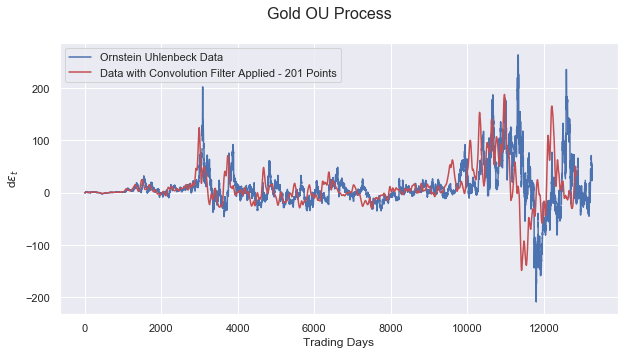

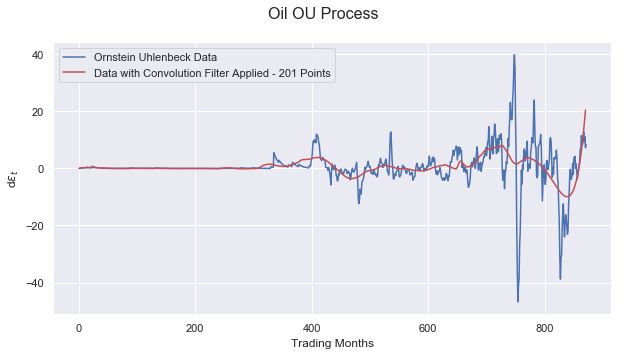

In [6]:
def OrnsteinUhlenbeck(data,col_name,residual,volatility,alpha,mu,brownian_motion):
    """
    This method returns the rate levels of a mean-reverting ornstein uhlenbeck process.
    :return: the returns of the Ornstein Uhlenbeck process
    """
    ou_levels = data.set_index('Date')[col_name].tolist()
    volatility=volatility.set_index('Date')**0.5
    volatility = np.array(volatility[col_name].tolist())
    delta = 1/252
    theta = 1-alpha
    epsilon = residual
    time = data.loc[0:len(data), :].index
    ou_returns = theta*epsilon[col_name] + volatility*brownian_motion
    
    return ou_returns,theta

ou_returns_gold,theta_gold = \
    OrnsteinUhlenbeck(gold_data,col_name_gold,gold_residual,gold_volatility,gold_alpha,\
                      gold_ema_short,gold_brownian_motion)
ou_returns_oil,theta_oil = \
    OrnsteinUhlenbeck(oil_data,col_name_oil,oil_residual,oil_volatility,oil_alpha,\
                      oil_ema_short,oil_brownian_motion)


def plot_stochastic_processes(data,processes,title,col_name,size,frequency):
    #Plots the OU process data
    fig, ax = plt.subplots(figsize=(10,5))
    fig.suptitle(title, fontsize=16)
    ax.set_xlabel('Trading ' + str(frequency))
    ax.set_ylabel('d' + r'$\epsilon_{t}$')
    x_axis = data.loc[0:len(data), :].index
    ax.plot(x_axis, processes,label='Ornstein Uhlenbeck Data')
    
    #Applies a Savitzky-Golay convolutional filter to smooth the graph
    #See report for more details on determining parameters
    points = 201
    yhat = savitzky_golay(processes.dropna(), points, 6)
    short = size/50
    x_axis_2 = range(0,len(processes.dropna()))
    ax.plot(x_axis_2, yhat, 'r', label='Data with Convolution Filter Applied - '+ str(points) + ' Points')   
    ax.legend(loc='best')
    plt.show()
    
    return yhat

gold_filtered_returns = plot_stochastic_processes(gold_data,ou_returns_gold, \
                                             'Gold OU Process', \
                                             col_name_gold, size_gold, 'Days'\
                                             )
oil_filtered_returns = plot_stochastic_processes(oil_data,ou_returns_oil, \
                                             'Oil OU Process', \
                                             col_name_oil, size_oil, 'Months'\
                                             )


In [7]:
#Stationarity Testing - see report for more details

def dickey_fuller(dataframe,col_name):
    # Output the results of the Augmented Dickey-Fuller test
    return ts.adfuller(dataframe[col_name],1)

#Gold Statistics
print('Durbin Watson Statistic = ' + str(tm.durbin_watson(ou_returns_gold.reset_index().dropna()[col_name_gold])))
'''
This is close to zero which presents evidence of positive serial correlation.
Hence, augmented dickey-fuller test can be used
'''
result = dickey_fuller(ou_returns_gold.reset_index().dropna(),col_name_gold)
print('ADF Statistic: %f' % result[0])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

#Oil Statistics
print('Durbin Watson Statistic = ' + str(tm.durbin_watson(ou_returns_oil.reset_index().dropna()[col_name_oil])))
result = dickey_fuller(ou_returns_oil.reset_index().dropna(),col_name_oil)
print('ADF Statistic: %f' % result[0])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Durbin Watson Statistic = 0.0147439992805
ADF Statistic: -7.066134
Critical Values:
	5%: -2.862
	1%: -3.431
	10%: -2.567
Durbin Watson Statistic = 0.161092438191
ADF Statistic: -8.893620
Critical Values:
	5%: -2.865
	1%: -3.438
	10%: -2.569


In [8]:
def zero_crossings(y_axis, x_axis = None):
    """
    Algorithm to find zero crossings. Finds the
    zero-crossings by looking for a sign change.
    """
    
    length = len(y_axis)
    if x_axis == None:
        x_axis = range(length)
    
    x_axis = np.asarray(x_axis)
    
    zero_crossings = np.where(np.diff(np.sign(y_axis)))[0]
    times = [x_axis[indice] for indice in zero_crossings]
    
    #check if zero-crossings are valid
    diff = np.diff(times)
    
    return times

def find_nearest_above(my_array, target):
    diff = my_array - target
    mask = np.ma.less_equal(diff, 0)
    # We need to mask the negative differences and zero
    # since we are looking for values above
    if np.all(mask):
        return None # returns None if target is greater than any value
    masked_diff = np.ma.masked_array(diff, mask)
    return masked_diff.argmin()

def dist_time(ou_returns,filtered_returns):
    wave = filtered_returns
    date = ou_returns.reset_index()['Date'].tolist()
    time = [i for i in range(0,len(ou_returns))]

    border = 0
    peaks = scipy.signal.find_peaks(wave,height=border)
    peaks = peaks[0]
    distance = []
    height = []
    array = zero_crossings(wave, time)

    for i in range(len(peaks)):
        value = peaks[i]
        near = find_nearest_above(array, value)
        near2 = find_nearest_above(peaks, value)
        if near!=None:
            t = array[near] - value
            h = wave[value]
            height.append(h)
            distance.append(t)
    return wave,peaks,height,distance

wave_gold, peaks_gold, height_gold, dist_gold = dist_time(ou_returns_gold,gold_filtered_returns)
wave_oil, peaks_oil, height_oil, dist_oil = dist_time(ou_returns_oil,oil_filtered_returns)

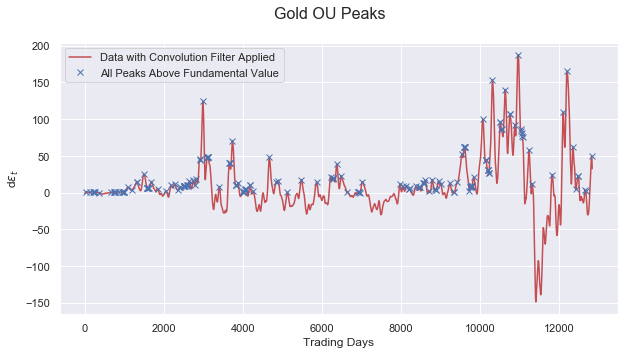

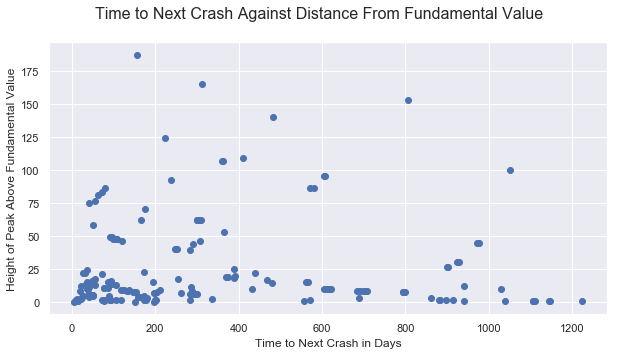

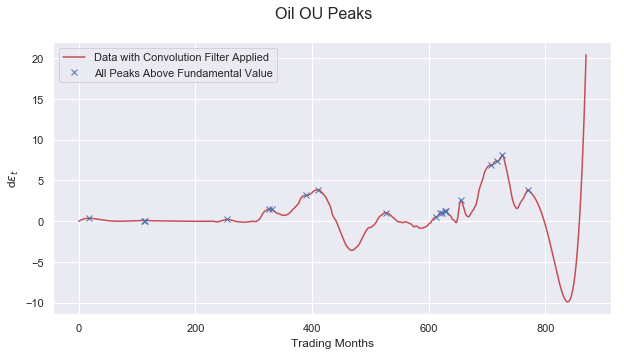

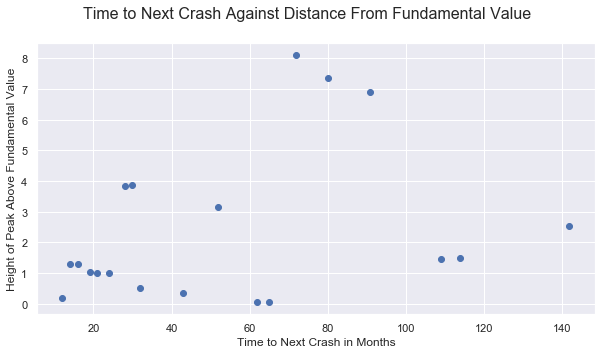

In [9]:
def plot_graphs(title,wave,peaks,height,distance,frequency):
    plt.figure(figsize=(10,5))
    plt.suptitle(title, fontsize=16)
    plt.plot(wave,'r',label='Data with Convolution Filter Applied')
    plt.plot(peaks, wave[peaks], "x",label='All Peaks Above Fundamental Value')
    plt.xlabel("Trading " + str(frequency))
    plt.ylabel('d' + r'$\epsilon_{t}$')
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(10,5))
    plt.scatter(distance,height)
    plt.suptitle("Time to Next Crash Against Distance From Fundamental Value", fontsize=16)
    plt.xlabel("Time to Next Crash in " + str(frequency))
    plt.ylabel("Height of Peak Above Fundamental Value")
    plt.show()
    
plot_graphs('Gold OU Peaks',wave_gold,peaks_gold,height_gold,dist_gold,"Days")
plot_graphs('Oil OU Peaks',wave_oil,peaks_oil,height_oil, dist_oil,"Months")

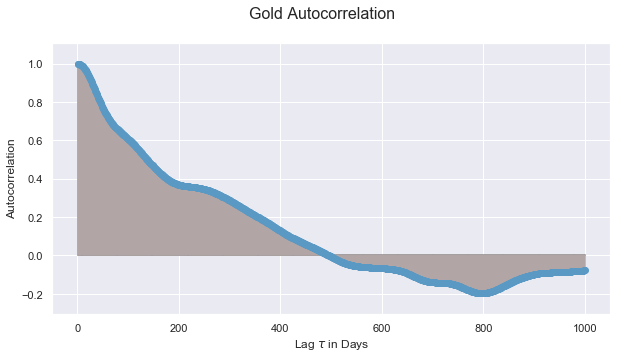

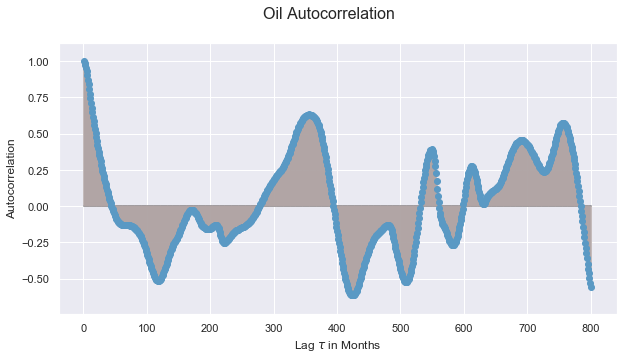

In [13]:
#Autocorrelation Plots - see report for more details
def lag_cal(time_srs, tot_lag):
    """
    This function calculates the autocorrelation lag of a given time series.
    
    time_srs: numpy array or list. It should be a 1*n array (only values of the variable we are considering).
    tot_lag: number of lags we want our correlation to estimate.
    """
    data_frame_time_srs = pd.DataFrame(time_srs, columns=["values"])
    lag_cal = []
    for num_lag in range(1, tot_lag+1):
        lag_cal.append(data_frame_time_srs["values"].autocorr(lag=num_lag))
    return np.array(lag_cal)

def lag_graph(title, lag_array, num_periods, frequency):
    """
    This function plots the autocorrelation function
    
    lag_array: array that contains the result of the autocorrelation function. np array or pandas series.
    num_periods: number of periods of the time series.
    frequency: frequency of the given data.
    """
    fig, ax = plt.subplots(figsize=(10,5))
    fig.suptitle(title, fontsize=16)
    x = np.arange(1, len(lag_array)+1)
    ax.plot(np.linspace(1,len(lag_array)), np.repeat(0, len(np.linspace(1,len(lag_array)))), 
             "-", color="#526774")
    for i in range(len(lag_array)):
        ax.plot(np.repeat(i+1,len(np.linspace(0, lag_array[i]))),
                 np.linspace(0, lag_array[i]), "-", color="#B1A5A5")
    ax.plot(x, lag_array, "o", color="#5A99C4")
    x1, x2, y1, y2 = ax.axis()
    ax.axis((x1-0.3, x2+0.9, y1-0.05, y2+0.05))
    ax.set_xlabel('Lag ' + r'$\tau$' + ' in ' + str(frequency))
    ax.set_ylabel('Autocorrelation')
    plt.show()
    
#Gold Price - 1000 lags and time period of 1 day
lag = lag_cal(gold_filtered_returns,1000)
T = 1 
lag_graph('Gold Autocorrelation',lag,T,'Days')

#Crude Oil Price - 800 lags and time period of 1 month
lag = lag_cal(oil_filtered_returns,800)
T = 1 
lag_graph('Oil Autocorrelation',lag,T,'Months')